Requisitos y **librerías** necesarias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import math
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

#### 1.1 Carga de datos y data wrangling

In [3]:
# Cargar los datos de los archivos
wd = pd.read_csv('WD.csv', decimal='.')
wdi = pd.read_csv('WDI.csv', decimal='.')
wgi = pd.read_csv('WGI.csv', decimal='.')

Inspección de datos cargados: podemos inspeccionar un dato suelto para ver si está bien cargados

In [4]:
wdi.iloc[0]['2000 [YR2000]']

'8.054'

Vemos que a pesar de haberle forzado el decimal con el carácter . nos está interpretando los
números como str, lo que es raro. Este es el primer indicador de que hay algo en las columnas
de variable que no está como debería. (Todas las variables son numéricas; no existen
variables categóricas)

In [5]:
# Inspeccionar las primeras filas de cada dataset
print("WD.csv - Datos de extensión, población y densidad:")
wd.head()

WD.csv - Datos de extensión, población y densidad:


,Country Name,Country Code,Series Name,Series Code,2018 [YR2018],2000 [YR2000]
0,Afghanistan,AFG,Land area (sq. km),LAND_AREA,652230,652230
1,Afghanistan,AFG,Population total,POPULATION,36686784,19542982
2,Afghanistan,AFG,Population density (people per sq. km of land ...,DENSITY,56.2482314520951,29.963328887049
3,Afghanistan,AFG,Population growth (annual %),POP_GROW,2.88520797304849,1.4438030241194
4,Albania,ALB,Land area (sq. km),LAND_AREA,27400,27400


In [6]:
print("WDI.csv - Indicadores de desarrollo:")
wdi.head()

WDI.csv - Indicadores de desarrollo:


,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2018 [YR2018]
0,Afghanistan,AFG,Unemployment total (% of total labor force),UNEMPLOY,8.054,11.11
1,Afghanistan,AFG,Consumer price index (2010 = 100),CPI,..,146.522481857209
2,Afghanistan,AFG,Death rate (per 1000 people),DEATH_RATE,12.096,6.981
3,Afghanistan,AFG,GDP per capita (constant 2015 US$),GDP.PCAP,..,578.985544847804
4,Afghanistan,AFG,Life expectancy at birth (years),LIFE_EXPECT,55.298,63.081


In [7]:
print("WGI.csv - Indicadores de gobernabilidad:")
wgi.head()

WGI.csv - Indicadores de gobernabilidad:


,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2018 [YR2018]
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.27172422409058,-1.48977172374725
1,Afghanistan,AFG,Control of Corruption: Standard Error,CC.STD.ERR,0.346905559301376,0.155046001076698
2,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-2.17394614219666,-1.47929918766022
3,Afghanistan,AFG,Government Effectiveness: Standard Error,GE.STD.ERR,0.331546425819397,0.2428357899189
4,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.43896889686584,-2.76386427879334


Vemos varios valores con .. en las cabeceras, que nos dicen que hay elementos no numéricos que están impidiendo que las columnas se carguen como números

Realizaremos la **integración de los 3 datasets** para obtener una estructura coherente:

In [8]:
# Inspeccionar columnas relevantes
print("Columnas de WD:", wd.columns)
print("Columnas de WDI:", wdi.columns)
print("Columnas de WGI:", wgi.columns)

Columnas de WD: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2018 [YR2018]', '2000 [YR2000]'],
      dtype='object')
Columnas de WDI: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2000 [YR2000]', '2018 [YR2018]'],
      dtype='object')
Columnas de WGI: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2000 [YR2000]', '2018 [YR2018]'],
      dtype='object')


In [9]:
# Realizar una unificación inicial basada en el nombre del país
merged_data = pd.merge(wd, wdi, how="outer")
merged_data = pd.merge(merged_data, wgi, how="outer")

In [10]:
# Inspeccionar el dataset unificado
print("Dataset unificado:\n")
merged_data.head()

Dataset unificado:



,Country Name,Country Code,Series Name,Series Code,2018 [YR2018],2000 [YR2000]
0,Afghanistan,AFG,Consumer price index (2010 = 100),CPI,146.522481857209,..
1,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.48977172374725,-1.27172422409058
2,Afghanistan,AFG,Control of Corruption: Standard Error,CC.STD.ERR,0.155046001076698,0.346905559301376
3,Afghanistan,AFG,Death rate (per 1000 people),DEATH_RATE,6.981,12.096
4,Afghanistan,AFG,GDP per capita (constant 2015 US$),GDP.PCAP,578.985544847804,..


Vamos a intentar solucionar los problemas de los datos numéricos, convertimos los datos a numéricos:

In [11]:
try:
    result = pd.to_numeric(merged_data['2018 [YR2018]'], errors='raise')
    print("Resultado parcial de la conversión:\n", result.head())
except Exception as e:
    print(f"Error durante la conversión: {e}")

Error durante la conversión: Unable to parse string ".." at position 22


Como vemos, al intentarlo, obtenemos un error que nos dice que el sistema no es capaz, ya que encuentra un valor .. en la posición 22. Como ya vemos que hay caracteres inesperados, debemos convertir éstos a NaN para poder seguir. Para ello, basta con utilizar el argumento coerce de la función .to_numeric, que convierte en NaN los valores que no es capaz de manejar en la conversión a números:

In [12]:
# Convertir a numéricas las columnas de datos
merged_data['2018 [YR2018]'] = pd.to_numeric(merged_data['2018 [YR2018]'], errors='coerce')
merged_data['2000 [YR2000]'] = pd.to_numeric(merged_data['2000 [YR2000]'], errors='coerce')

In [13]:
# Visualizar los datos
merged_data.head()

,Country Name,Country Code,Series Name,Series Code,2018 [YR2018],2000 [YR2000]
0,Afghanistan,AFG,Consumer price index (2010 = 100),CPI,146.522482,NaN
1,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.489772,-1.271724
2,Afghanistan,AFG,Control of Corruption: Standard Error,CC.STD.ERR,0.155046,0.346906
3,Afghanistan,AFG,Death rate (per 1000 people),DEATH_RATE,6.981000,12.096000
4,Afghanistan,AFG,GDP per capita (constant 2015 US$),GDP.PCAP,578.985545,NaN


Realizamos un primer fundido de los datos anuales a la columna Year, manteniendo el resto igual:

In [14]:
melted_data = pd.melt(merged_data, id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'], var_name="Year", value_name="Variable Value")
melted_data

,Country Name,Country Code,Series Name,Series Code,Year,Variable Value
0,Afghanistan,AFG,Consumer price index (2010 = 100),CPI,2018 [YR2018],146.522482
1,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,2018 [YR2018],-1.489772
2,Afghanistan,AFG,Control of Corruption: Standard Error,CC.STD.ERR,2018 [YR2018],0.155046
3,Afghanistan,AFG,Death rate (per 1000 people),DEATH_RATE,2018 [YR2018],6.981000
4,Afghanistan,AFG,GDP per capita (constant 2015 US$),GDP.PCAP,2018 [YR2018],578.985545
...,...,...,...,...,...,...
11699,Zimbabwe,ZWE,Rule of Law: Estimate,RL.EST,2000 [YR2000],-1.381908
11700,Zimbabwe,ZWE,Rule of Law: Standard Error,RL.STD.ERR,2000 [YR2000],0.170140
11701,Zimbabwe,ZWE,Unemployment total (% of total labor force),UNEMPLOY,2000 [YR2000],5.688000
11702,Zimbabwe,ZWE,Voice and Accountability: Estimate,VA.EST,2000 [YR2000],-1.085388


Para lograr la estructura pedida, haremos un pivot de la tabla, para transformar los pares de valores actuales de Series Code y Variable Value en claves de columna - valores. Para ello, hay que eliminar primero Series Name:

In [15]:
# Eliminar la columna
melted_data = melted_data.drop(columns='Series Name')

In [16]:
# Pivotar el dataset
tidy_data = pd.pivot(melted_data, index=['Country Name', 'Country Code','Year'], columns='Series Code', values='Variable Value')

In [17]:
# Resetear el índice tras el pivot
tidy_data = tidy_data.reset_index()
tidy_data['CC.STD.ERR'].iloc[0]

0.346905559301376

In [18]:
# Guardar el dataset final para futuras operaciones
tidy_data.to_csv("tidy_dataset.csv", index=False)
print("Dataset limpio guardado como tidy_dataset.csv")

Dataset limpio guardado como tidy_dataset.csv


La estructura seleccionada proporciona una vista unificada y relacional de los datos provenientes de múltiples fuentes (WD, WDI, y WGI). Esto facilita:
1. Análisis Comparativo: al tener los indicadores socioeconómicos y de gobernabilidad en un solo dataset, se pueden establecer comparaciones directas y relaciones entre las variables.
2. Estandarización: la integración bajo una clave común, como el nombre del país, permite evitar redundancias y consolidar la información dispersa.
3. Preparación para Data Mining: los métodos de minería de datos requieren estructuras bien organizadas y consistentes, lo que esta estructura permite.
4. Flexibilidad Analítica: la estructura simplificada facilita la generación de gráficos, estadísticas y modelos, sin necesidad de múltiples cruces durante el análisis.

#### 1.2 Tratamiento de datos faltantes, anómalos y erróneos

In [19]:
# Calcular el porcentaje de valores faltantes por columna
missing_data = tidy_data.isnull().mean() * 100
print("Porcentaje de valores faltantes por columna:\n")
print(missing_data, "\n")
missing_data = tidy_data.isnull().sum()
print("Número de valores faltantes por columna:\n")
print(missing_data, "\n")

Porcentaje de valores faltantes por columna:

Series Code
Country Name     0.000000
Country Code     0.000000
Year             0.000000
BIRTH_MORT       8.955224
CC.EST          27.425373
CC.STD.ERR      27.425373
CPI             35.447761
DEATH_RATE       2.425373
DENSITY          2.238806
GDP.PCAP         7.462687
GE.EST          28.358209
GE.STD.ERR      28.358209
LAND_AREA        2.238806
LIFE_EXPECT      3.731343
POPULATION       1.119403
POP_GROW         1.119403
PV.EST          26.865672
PV.STD.ERR      26.865672
RL.EST          25.000000
RL.STD.ERR      25.000000
RQ.EST          28.171642
RQ.STD.ERR      28.171642
UNEMPLOY        12.313433
VA.EST          25.000000
VA.STD.ERR      25.000000
dtype: float64 

Número de valores faltantes por columna:

Series Code
Country Name      0
Country Code      0
Year              0
BIRTH_MORT       48
CC.EST          147
CC.STD.ERR      147
CPI             190
DEATH_RATE       13
DENSITY          12
GDP.PCAP         40
GE.EST          152
G

Vemos que tenemos un porcentaje apreciable de datos faltantes en algunas variables, llegando incluso a valores cercanos al 30%. Hay muchas posibilidades en este apartado: 
1. Se debe hacer un análisis de que ciertas columnas o ciertas filas tienen demasiados pocos datos reales, y se debe considerar su eliminación íntegra de las mismas.
2. Para variables no eliminadas, al ser todas numéricas y continuas, se puede hacer imputación. Se pueden usar muchas técnicas; desde utilizar la mediana hasta buscar semejanzas geográficas o utilizar K-Means.

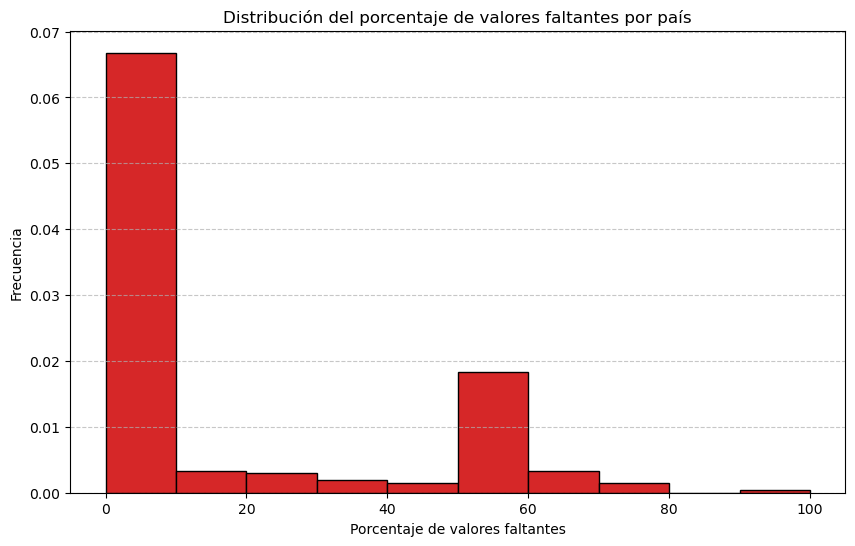

In [20]:
# Calcular el porcentaje de valores faltantes por país
nan_percentage_by_country = tidy_data.groupby('Country Name').apply(lambda x: x.isnull().sum().sum() / x.size * 100, include_groups=False)
bins = np.arange(0, nan_percentage_by_country.max() + 10, 10)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(nan_percentage_by_country, bins=bins, color='tab:red', edgecolor='black', density=True)
plt.title('Distribución del porcentaje de valores faltantes por país')
plt.xlabel('Porcentaje de valores faltantes')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Vemos que hay unos pocos paises con muchísimos datos faltantes, ya que la gran mayoría tienen menos del 60% de NaN

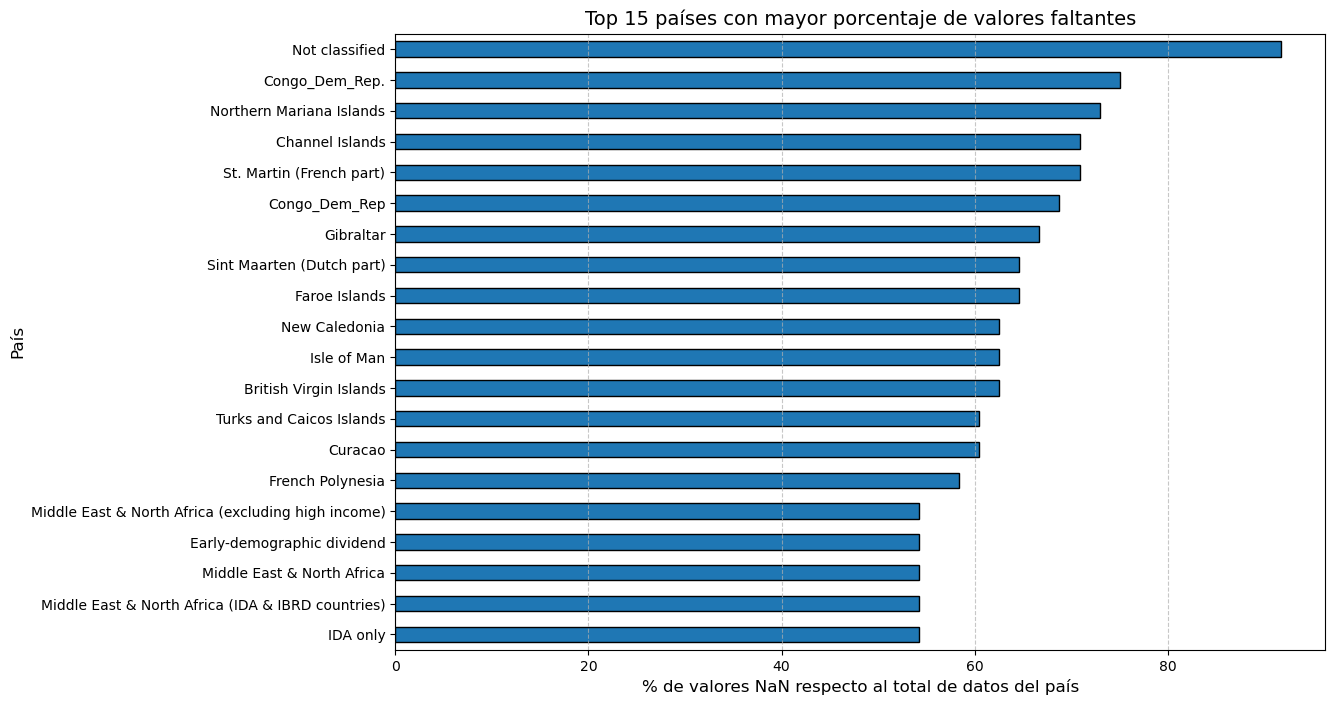

In [21]:
# Ordenar los países por porcentaje de valores NaN
nan_percentage_sorted = nan_percentage_by_country.sort_values(ascending=False)

# Seleccionar los top 15 países con más valores NaN
top_countries = nan_percentage_sorted.head(20)

# Crear un gráfico de barras
plt.figure(figsize=(12, 8))
top_countries.plot(kind='barh', color='tab:blue', edgecolor='black')
plt.title('Top 15 países con mayor porcentaje de valores faltantes', fontsize=14)
plt.xlabel('% de valores NaN respecto al total de datos del país', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() # Invertir el eje Y para mostrar el país con más NaNs arriba
plt.show()

In [22]:
# Identificar los países con más del 25% de valores faltantes
countries_to_remove = nan_percentage_by_country[nan_percentage_by_country > 60].index

# Contar cuántos países serán eliminados
num_countries_removed = len(countries_to_remove)
print(f"Número de países eliminados: {num_countries_removed}")

# Filtrar el dataset para eliminar esos países
filtered_data = tidy_data[~tidy_data['Country Name'].isin(countries_to_remove)]

# Confirmar el nuevo tamaño del dataset
print(f"Tamaño del dataset después de eliminar países: {filtered_data.shape}")

Número de países eliminados: 14
Tamaño del dataset después de eliminar países: (508, 25)


Para el resto de valores faltantes usaremos **KNN**

In [24]:
# Paso 1: seleccionar solo las columnas numéricas para imputar
numeric_columns = filtered_data.select_dtypes(include=['float64', 'int64']).columns

# Paso 2: escalar los datos para evitar problemas de magnitudes
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data[numeric_columns])

# Paso 3: imputar valores faltantes utilizando KNN (KNNImputer en sklearn)
imputer = KNNImputer(n_neighbors=5) 
imputed_data = imputer.fit_transform(scaled_data)

# Paso 4: restaurar el DataFrame original con los valores imputados
imputed_df = filtered_data.copy()
imputed_df[numeric_columns] = scaler.inverse_transform(imputed_data)

# Verificar si hay valores faltantes después de la imputación
remaining_na = imputed_df.isnull().sum().sum()
print(f"Valores faltantes restantes después de la imputación: {remaining_na}")

Valores faltantes restantes después de la imputación: 0


**Detección y gestión de outliers**: hay muchas opciones (Método del Rango Intercuartílico (IQR) - Distribución Gaussiana (Z-score) - Análisis Multivariado). En cualquier caso, se deben excluir las variables de tipo geográfico, como la población o la superficie, ya que son métricas con una división completamente artificial, y a priori deben excluirse las columnas con desviaciones típicas

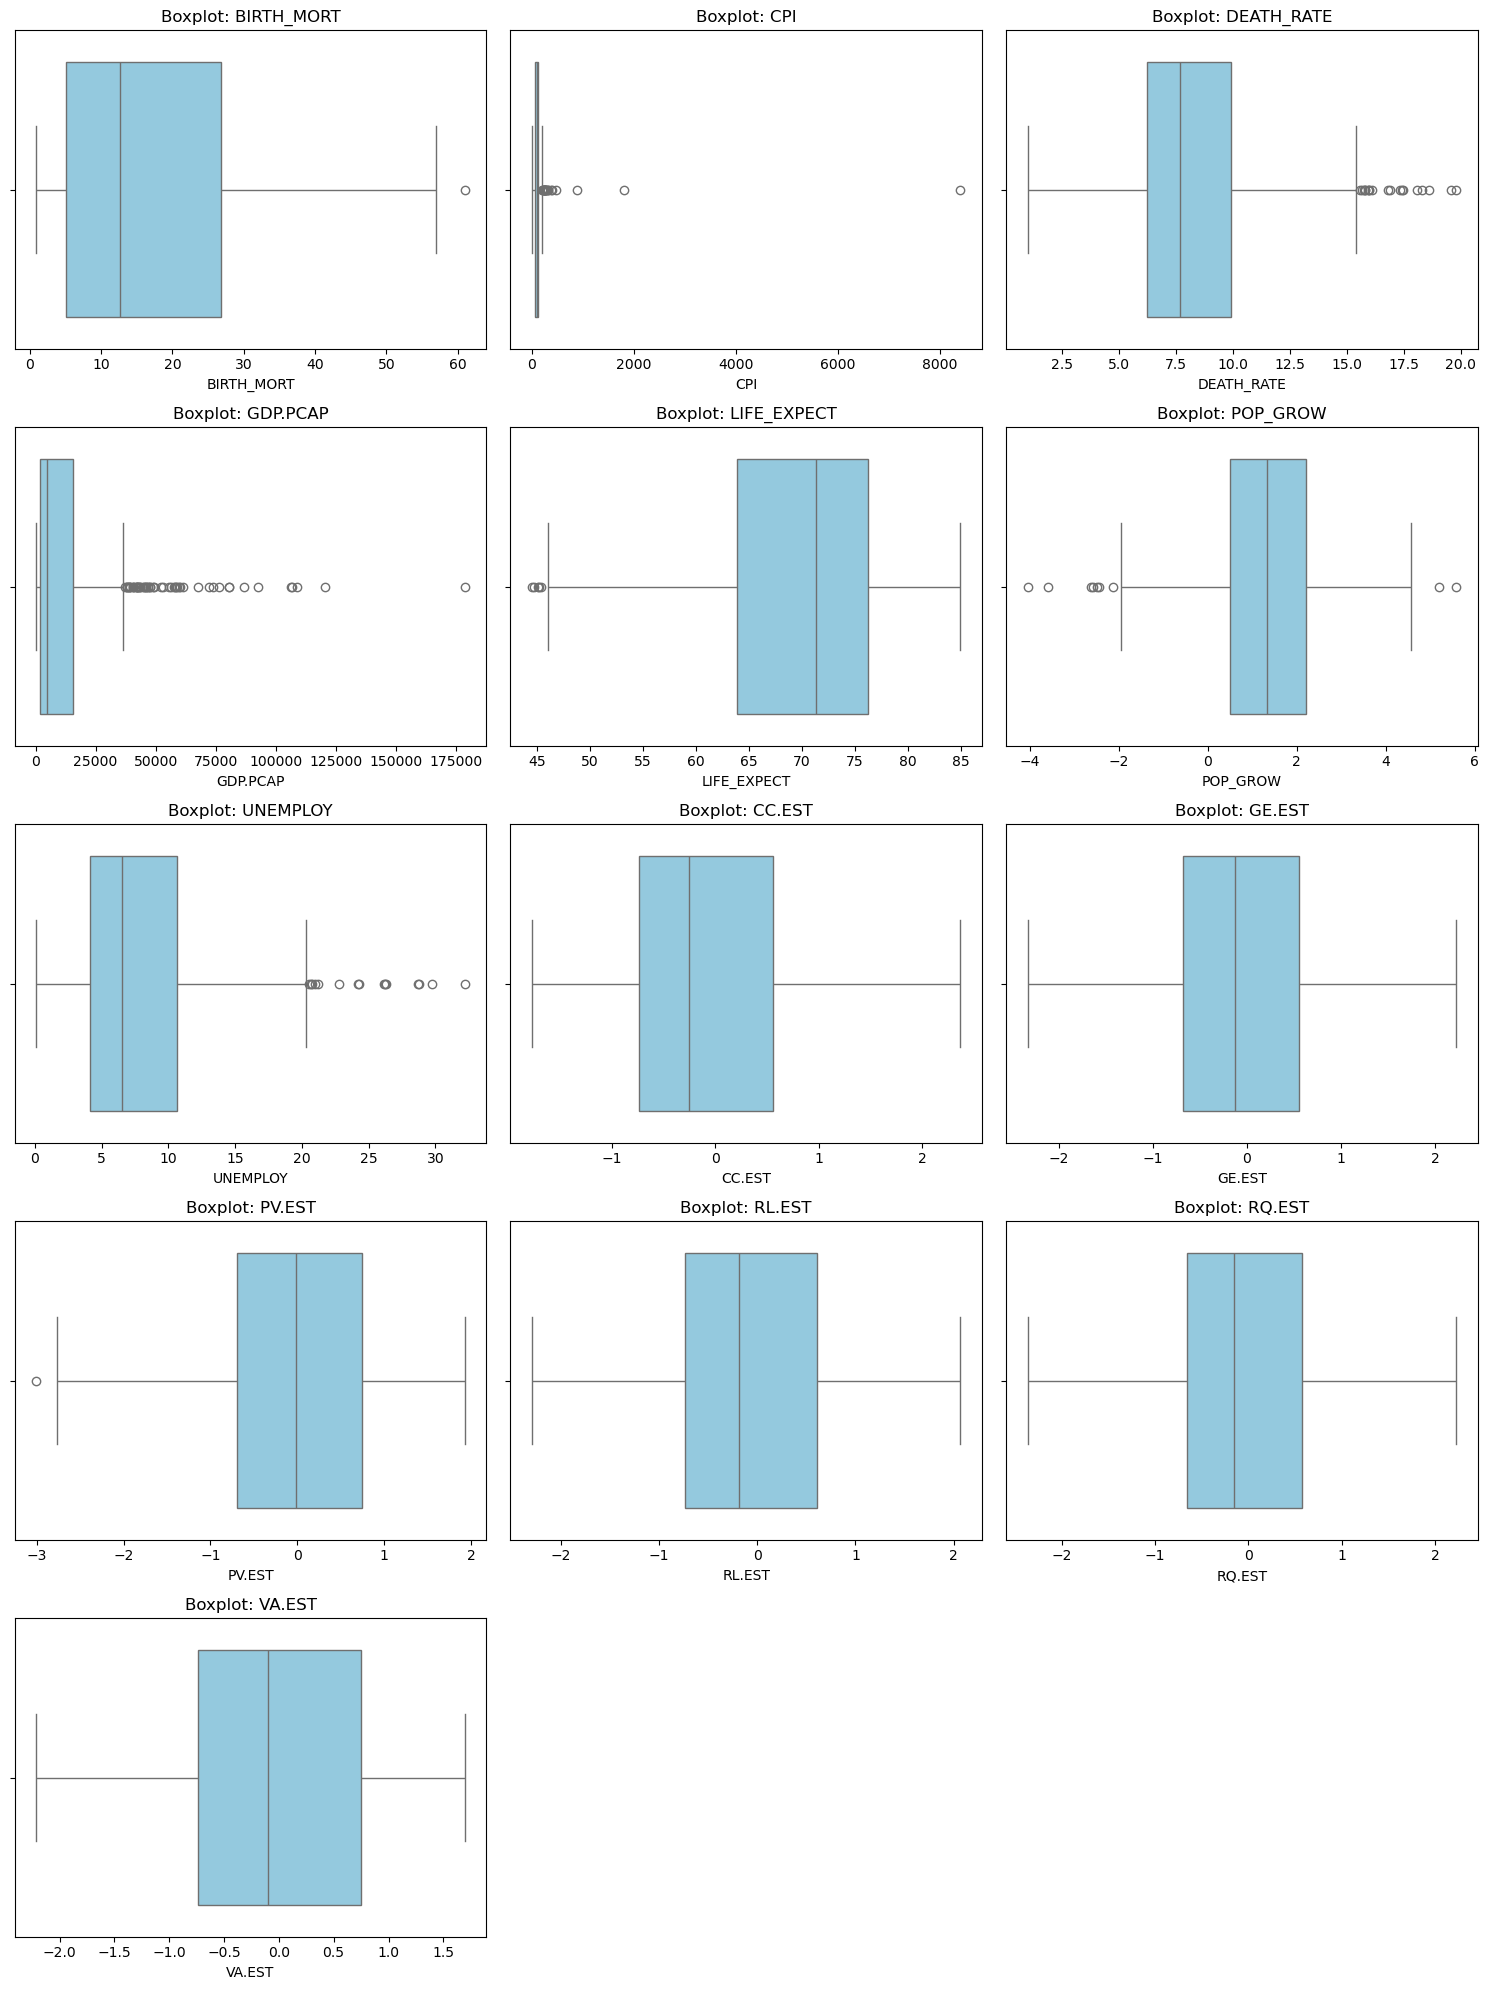

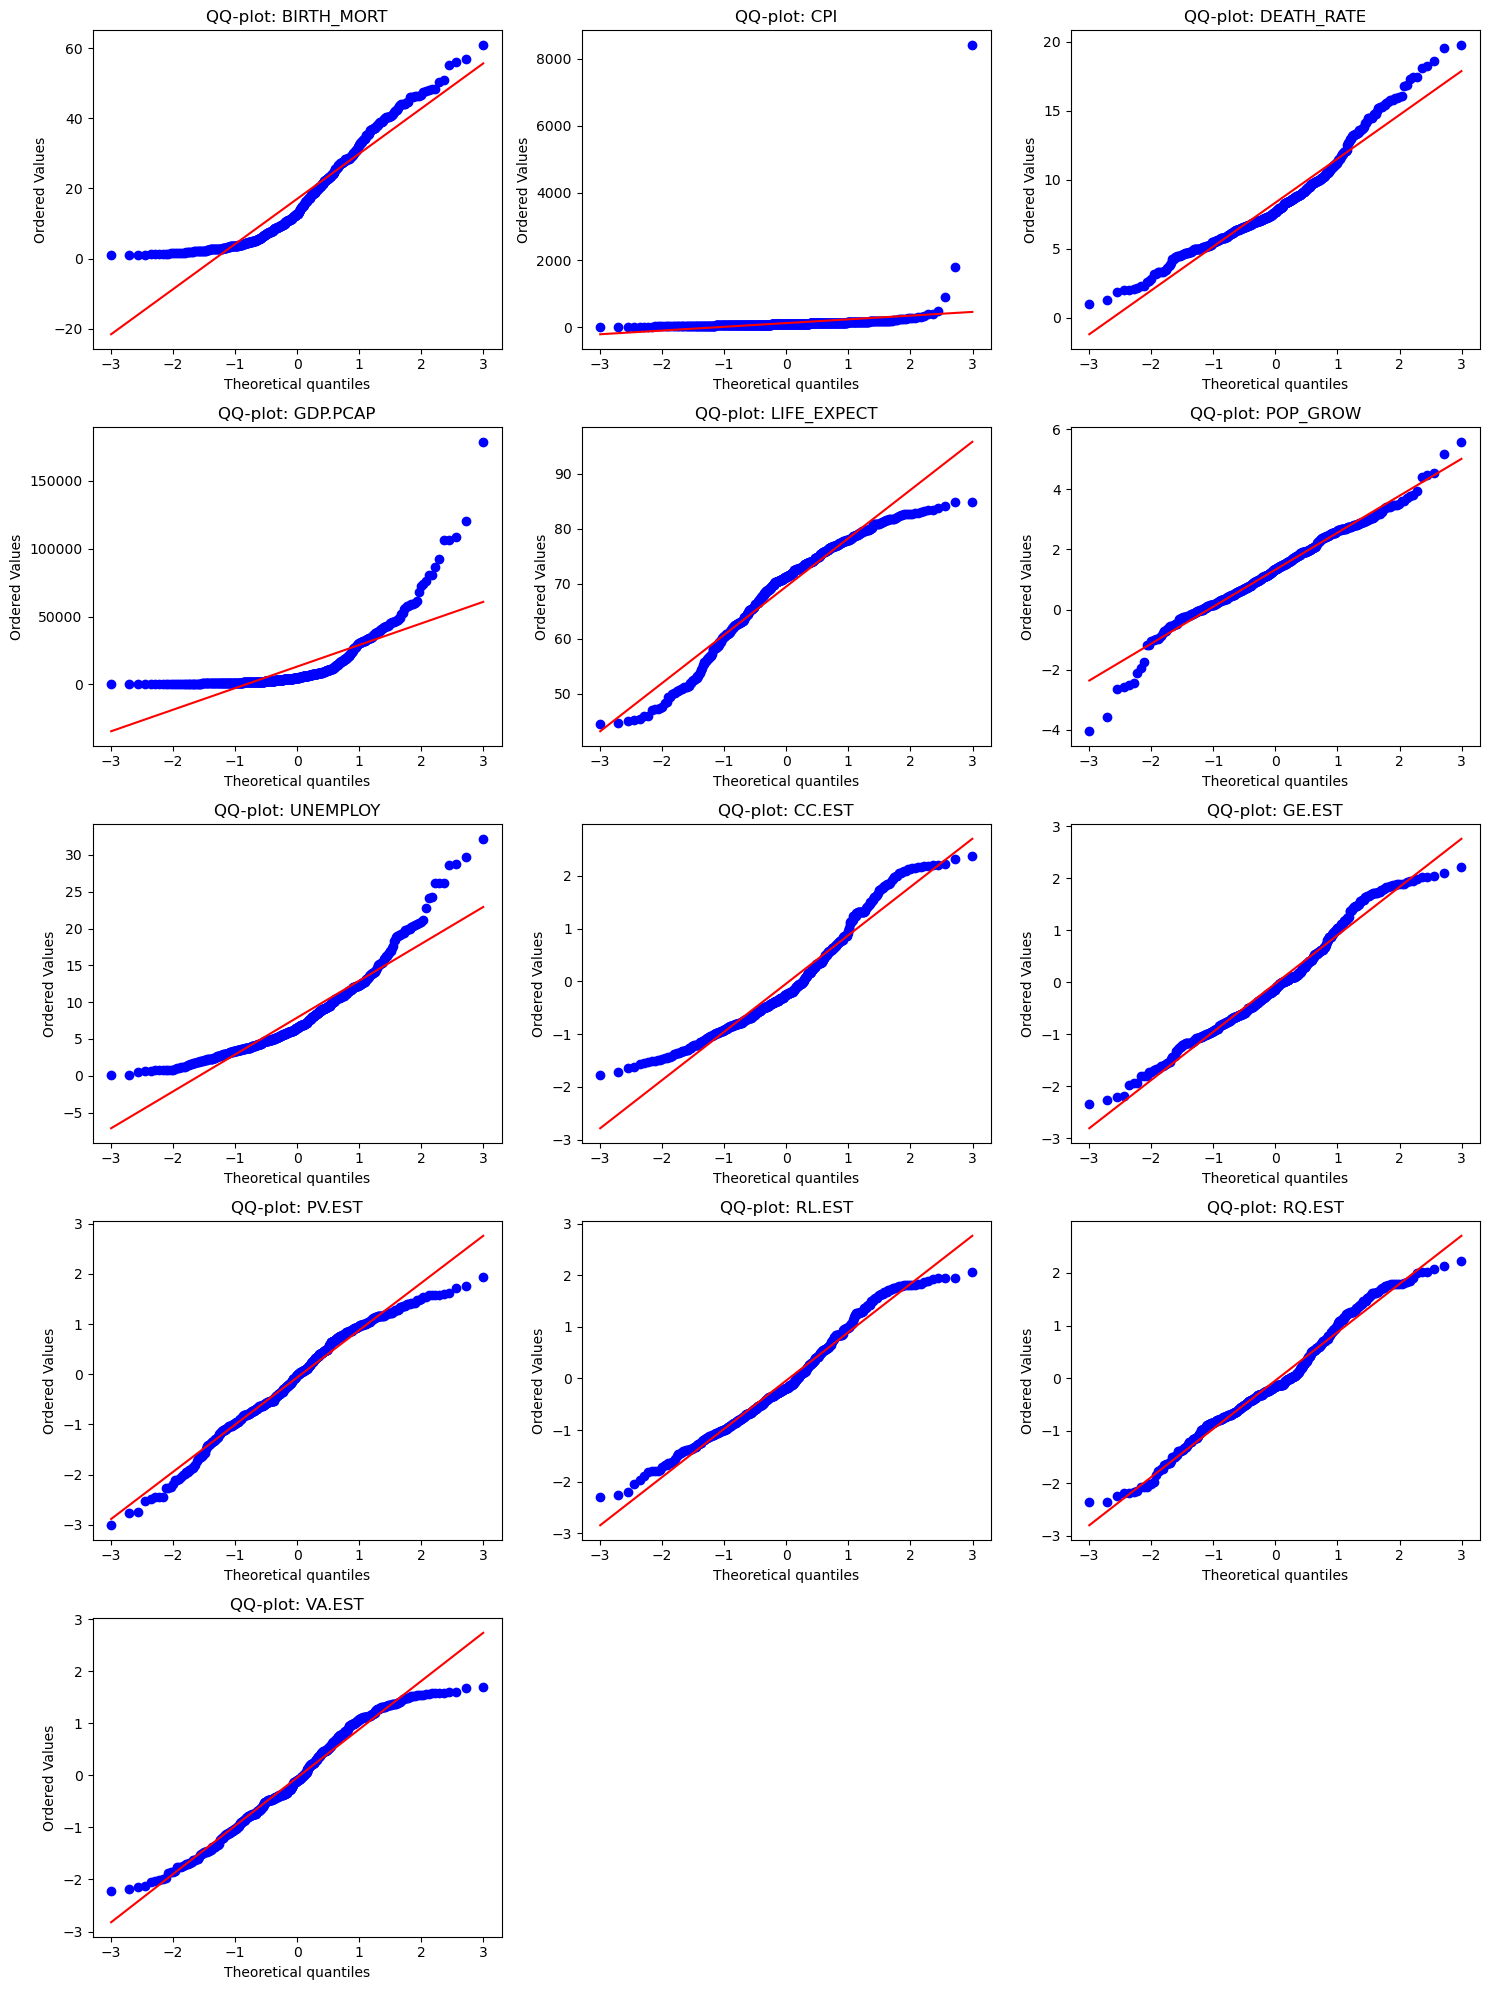

In [25]:
# Lista de columnas seleccionadas (excluyendo las .STD.ERR y variables geográficas)
reasonable_columns = [
'BIRTH_MORT', 'CPI', 'DEATH_RATE', 'GDP.PCAP',
'LIFE_EXPECT', 'POP_GROW', 'UNEMPLOY',
'CC.EST', 'GE.EST', 'PV.EST', 'RL.EST', 'RQ.EST', 'VA.EST'
]

# Determinar el número de filas y columnas para subplots
num_vars = len(reasonable_columns)
cols = 3 # Número de columnas deseado
rows = math.ceil(num_vars / cols)

# Paso 1: Crear boxplots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=imputed_df[col], color='skyblue')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# Paso 2: Crear QQ-plots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    stats.probplot(imputed_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-plot: {col}")
    
plt.tight_layout()
plt.show()

Los QQ-Plots parecen bastante normales, con algún dato claramente sin sentido, proablemente procedente de la elección arbitraria de los 𝐾 en K-Means, o bien procedente del dataset original. Podemos probar a normalizar las variables:

In [26]:
# Función para detectar y tratar outliers mediante normalización (z-scores)
def detect_and_count_outliers_zscore(df, column, threshold=3):

    # Calcular el z-score para la columna
    z_scores = zscore(df[column].dropna())
    outliers = (z_scores > threshold) | (z_scores < -threshold)

    # Contar valores fuera de los límites
    below_lower = (z_scores < -threshold).sum()
    above_upper = (z_scores > threshold).sum()
    total_outliers = below_lower + above_upper

    # Winsorización basada en z-scores
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return total_outliers, below_lower, above_upper

# Aplicar el tratamiento y contar outliers en cada columna razonable
outliers_summary_zscore = {}
for col in reasonable_columns:
    total_outliers, below_lower, above_upper = detect_and_count_outliers_zscore(imputed_df, col)
    outliers_summary_zscore[col] = {
        'total_outliers': total_outliers,
        'below_lower': below_lower,
        'above_upper': above_upper
    }
    print(f"Columna: {col}")
    print(f" Outliers totales: {total_outliers}")
    print(f" Por debajo del límite inferior: {below_lower}")
    print(f" Por encima del límite superior: {above_upper}\n")

# Resumen final
print("\nResumen de outliers tratados mediante normalización:")
for col, counts in outliers_summary_zscore.items():
    print(f"{col}: {counts['total_outliers']} outliers (Inferior: {counts['below_lower']}, Superior: {counts['above_upper']})")

Columna: BIRTH_MORT
 Outliers totales: 1
 Por debajo del límite inferior: 0
 Por encima del límite superior: 1

Columna: CPI
 Outliers totales: 2
 Por debajo del límite inferior: 0
 Por encima del límite superior: 2

Columna: DEATH_RATE
 Outliers totales: 5
 Por debajo del límite inferior: 0
 Por encima del límite superior: 5

Columna: GDP.PCAP
 Outliers totales: 11
 Por debajo del límite inferior: 0
 Por encima del límite superior: 11

Columna: LIFE_EXPECT
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Columna: POP_GROW
 Outliers totales: 8
 Por debajo del límite inferior: 6
 Por encima del límite superior: 2

Columna: UNEMPLOY
 Outliers totales: 9
 Por debajo del límite inferior: 0
 Por encima del límite superior: 9

Columna: CC.EST
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Columna: GE.EST
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Columna: P

In [27]:
# Función para detectar y tratar outliers con IQR, registrando la cantidad tratada
def detect_and_count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar valores fuera de los límites
    below_lower = df[column][df[column] < lower_bound].count()
    above_upper = df[column][df[column] > upper_bound].count()
    total_outliers = below_lower + above_upper

    # Winsorización: Limitar los valores extremos a los límites
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return total_outliers, below_lower, above_upper
    
# Aplicar el tratamiento y contar outliers en cada columna razonable
outliers_summary = {}
for col in reasonable_columns:
    total_outliers, below_lower, above_upper = detect_and_count_outliers(imputed_df, col)
    outliers_summary[col] = {
        'total_outliers': total_outliers,
        'below_lower': below_lower,
        'above_upper': above_upper
    }
    print(f"Columna: {col}")
    print(f" Outliers totales: {total_outliers}")
    print(f" Por debajo del límite inferior: {below_lower}")
    print(f" Por encima del límite superior: {above_upper}\n")

# Resumen final
print("\nResumen de outliers tratados:")
for col, counts in outliers_summary.items():
    print(f"{col}: {counts['total_outliers']} outliers (Inferior: {counts['below_lower']}, Superior: {counts['above_upper']})")

Columna: BIRTH_MORT
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Columna: CPI
 Outliers totales: 21
 Por debajo del límite inferior: 0
 Por encima del límite superior: 21

Columna: DEATH_RATE
 Outliers totales: 19
 Por debajo del límite inferior: 0
 Por encima del límite superior: 19

Columna: GDP.PCAP
 Outliers totales: 54
 Por debajo del límite inferior: 0
 Por encima del límite superior: 54

Columna: LIFE_EXPECT
 Outliers totales: 5
 Por debajo del límite inferior: 5
 Por encima del límite superior: 0

Columna: POP_GROW
 Outliers totales: 9
 Por debajo del límite inferior: 7
 Por encima del límite superior: 2

Columna: UNEMPLOY
 Outliers totales: 15
 Por debajo del límite inferior: 0
 Por encima del límite superior: 15

Columna: CC.EST
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Columna: GE.EST
 Outliers totales: 0
 Por debajo del límite inferior: 0
 Por encima del límite superior: 0

Colu

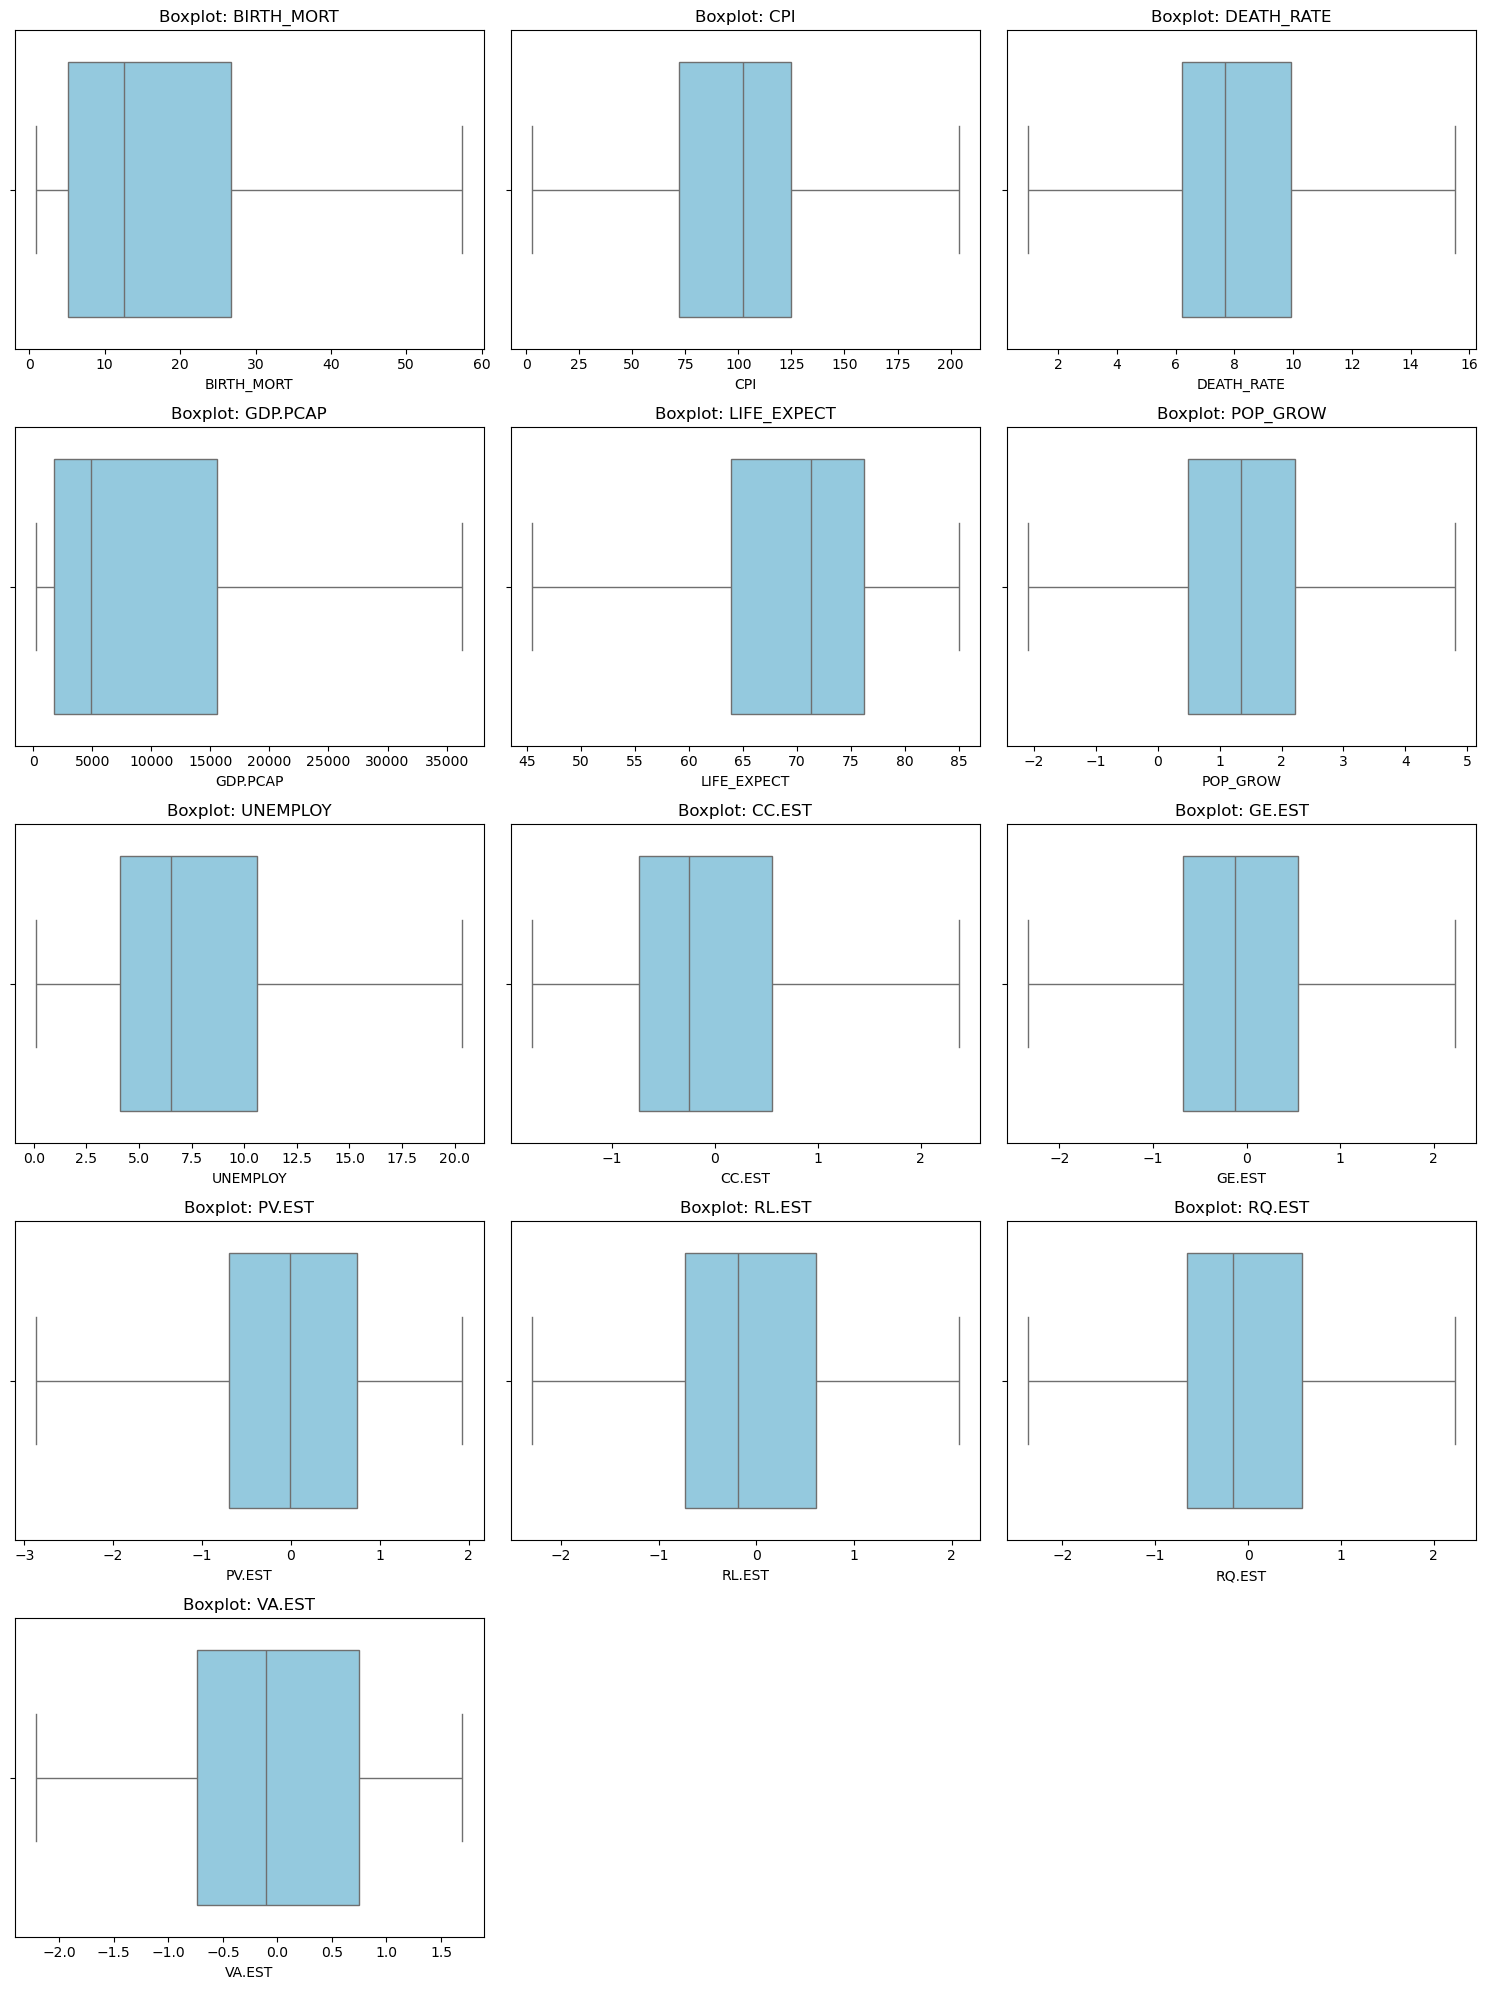

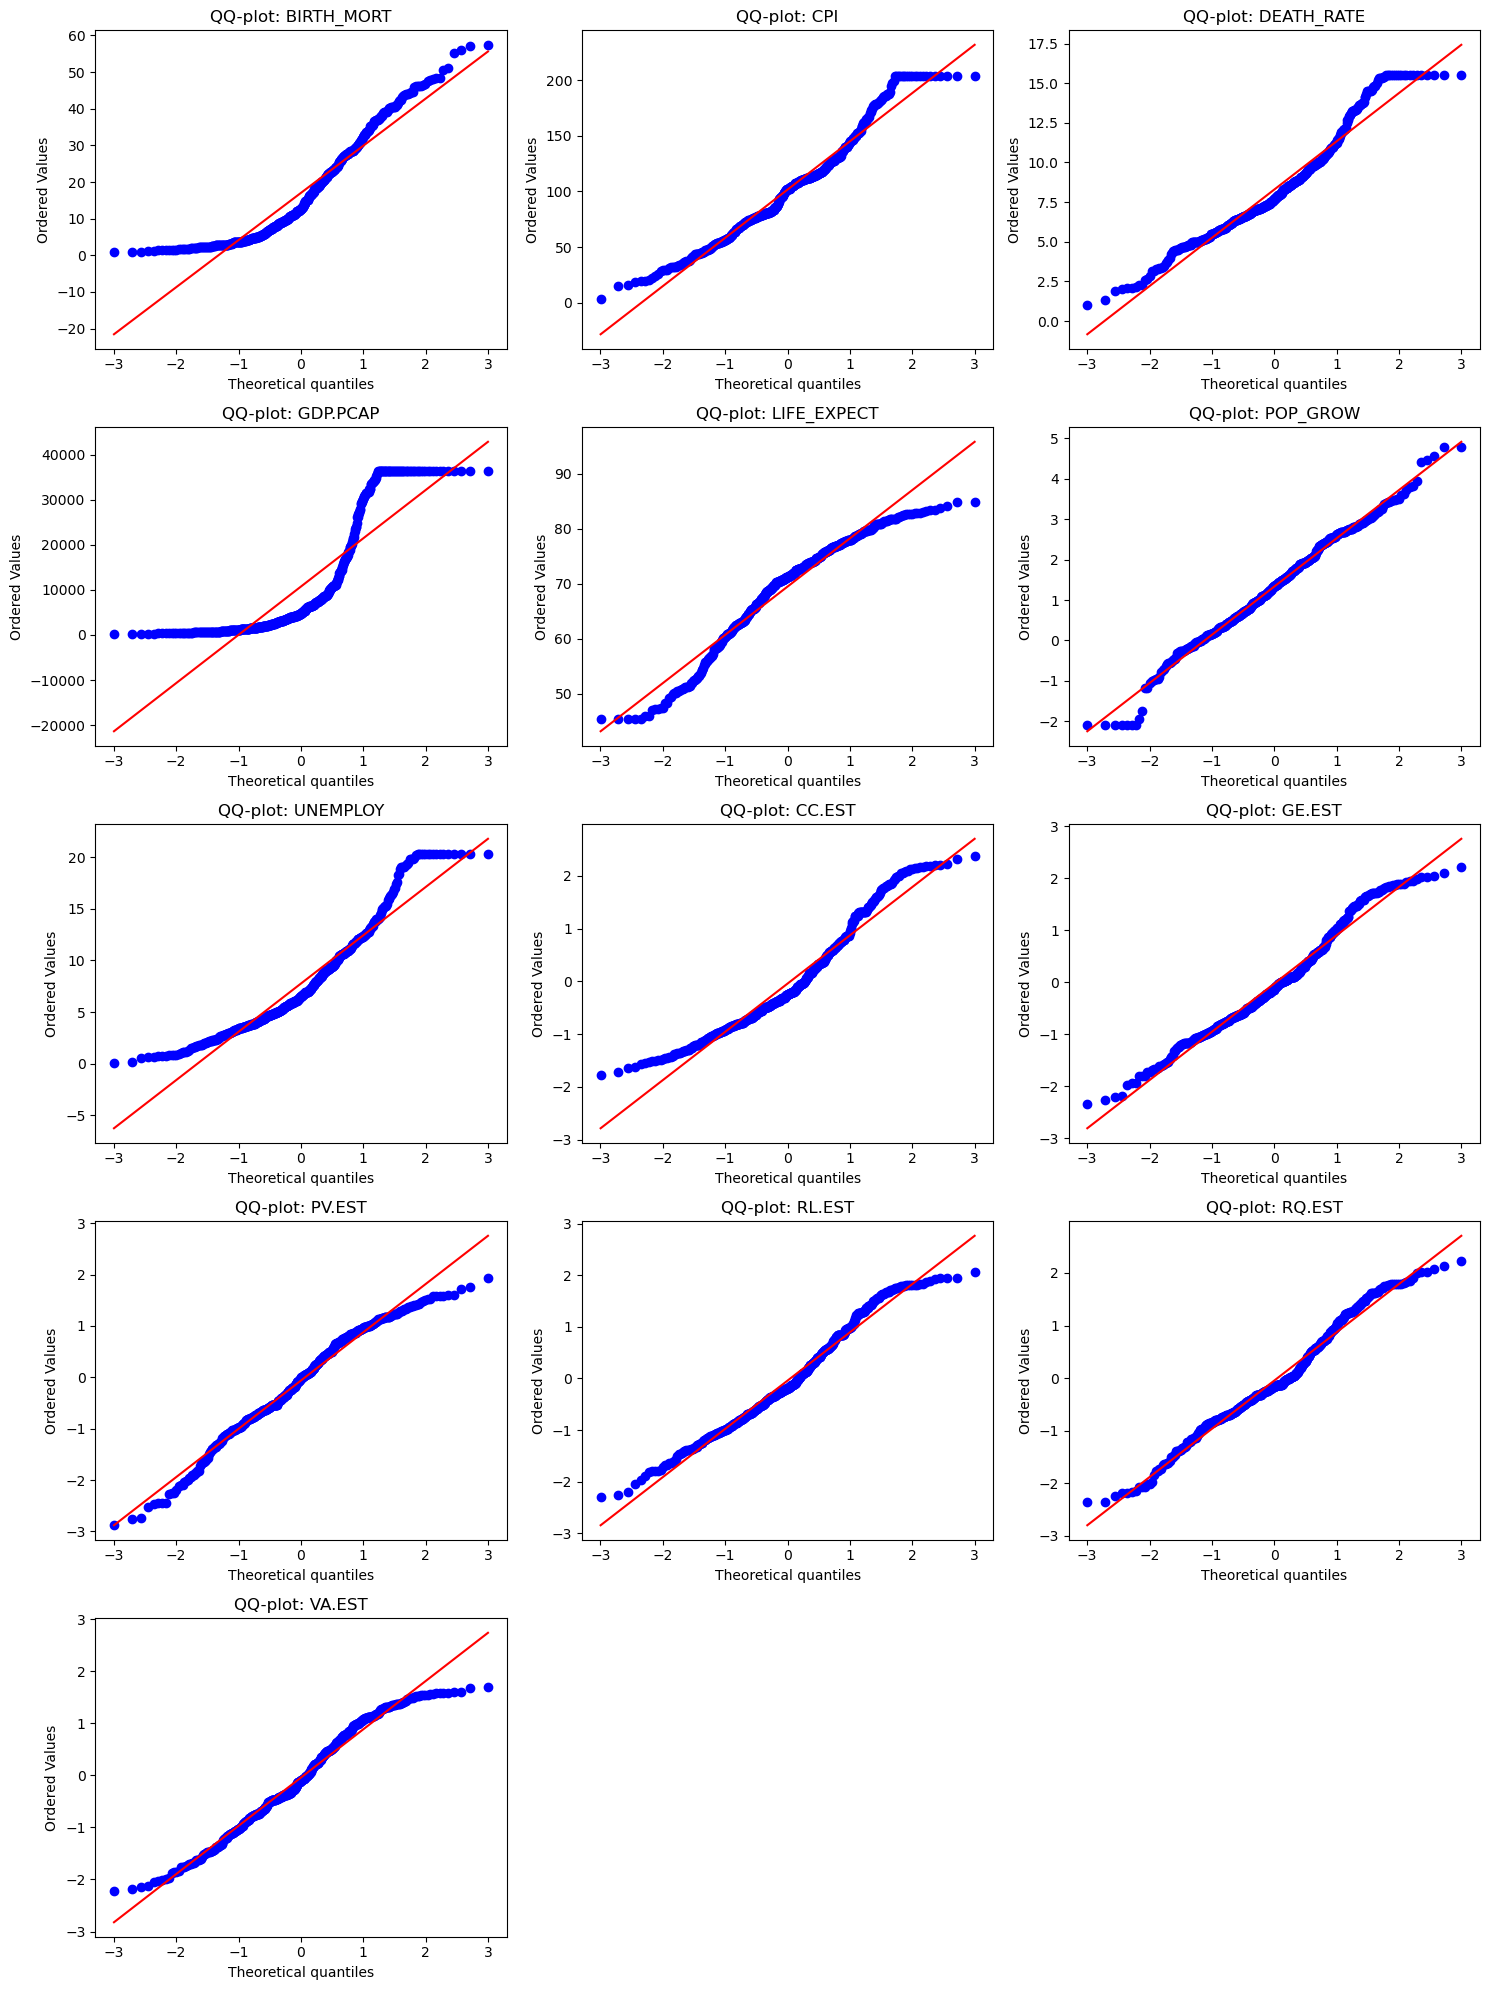

In [28]:
# Lista de columnas seleccionadas (excluyendo las .STD.ERR y variables geográficas)
reasonable_columns = [
    'BIRTH_MORT', 'CPI', 'DEATH_RATE', 'GDP.PCAP',
    'LIFE_EXPECT', 'POP_GROW', 'UNEMPLOY',
    'CC.EST', 'GE.EST', 'PV.EST', 'RL.EST', 'RQ.EST', 'VA.EST'
]

# Determinar el número de filas y columnas para subplots
num_vars = len(reasonable_columns)
cols = 3 # Número de columnas deseado
rows = math.ceil(num_vars / cols)

# Paso 1: Crear boxplots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=imputed_df[col], color='skyblue')
    plt.title(f"Boxplot: {col}")

plt.tight_layout()
plt.show()

# Paso 2: Crear QQ-plots para las variables razonables
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(reasonable_columns, 1):
    plt.subplot(rows, cols, i)
    stats.probplot(imputed_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-plot: {col}")

plt.tight_layout()
plt.show()

Observamos que se han eliminado los datos problemáticos

**Datos erróneos**: podemos asumir con los gráficos que no hay valores negativos o nulos

#### 1.3 Interpretación de resultados

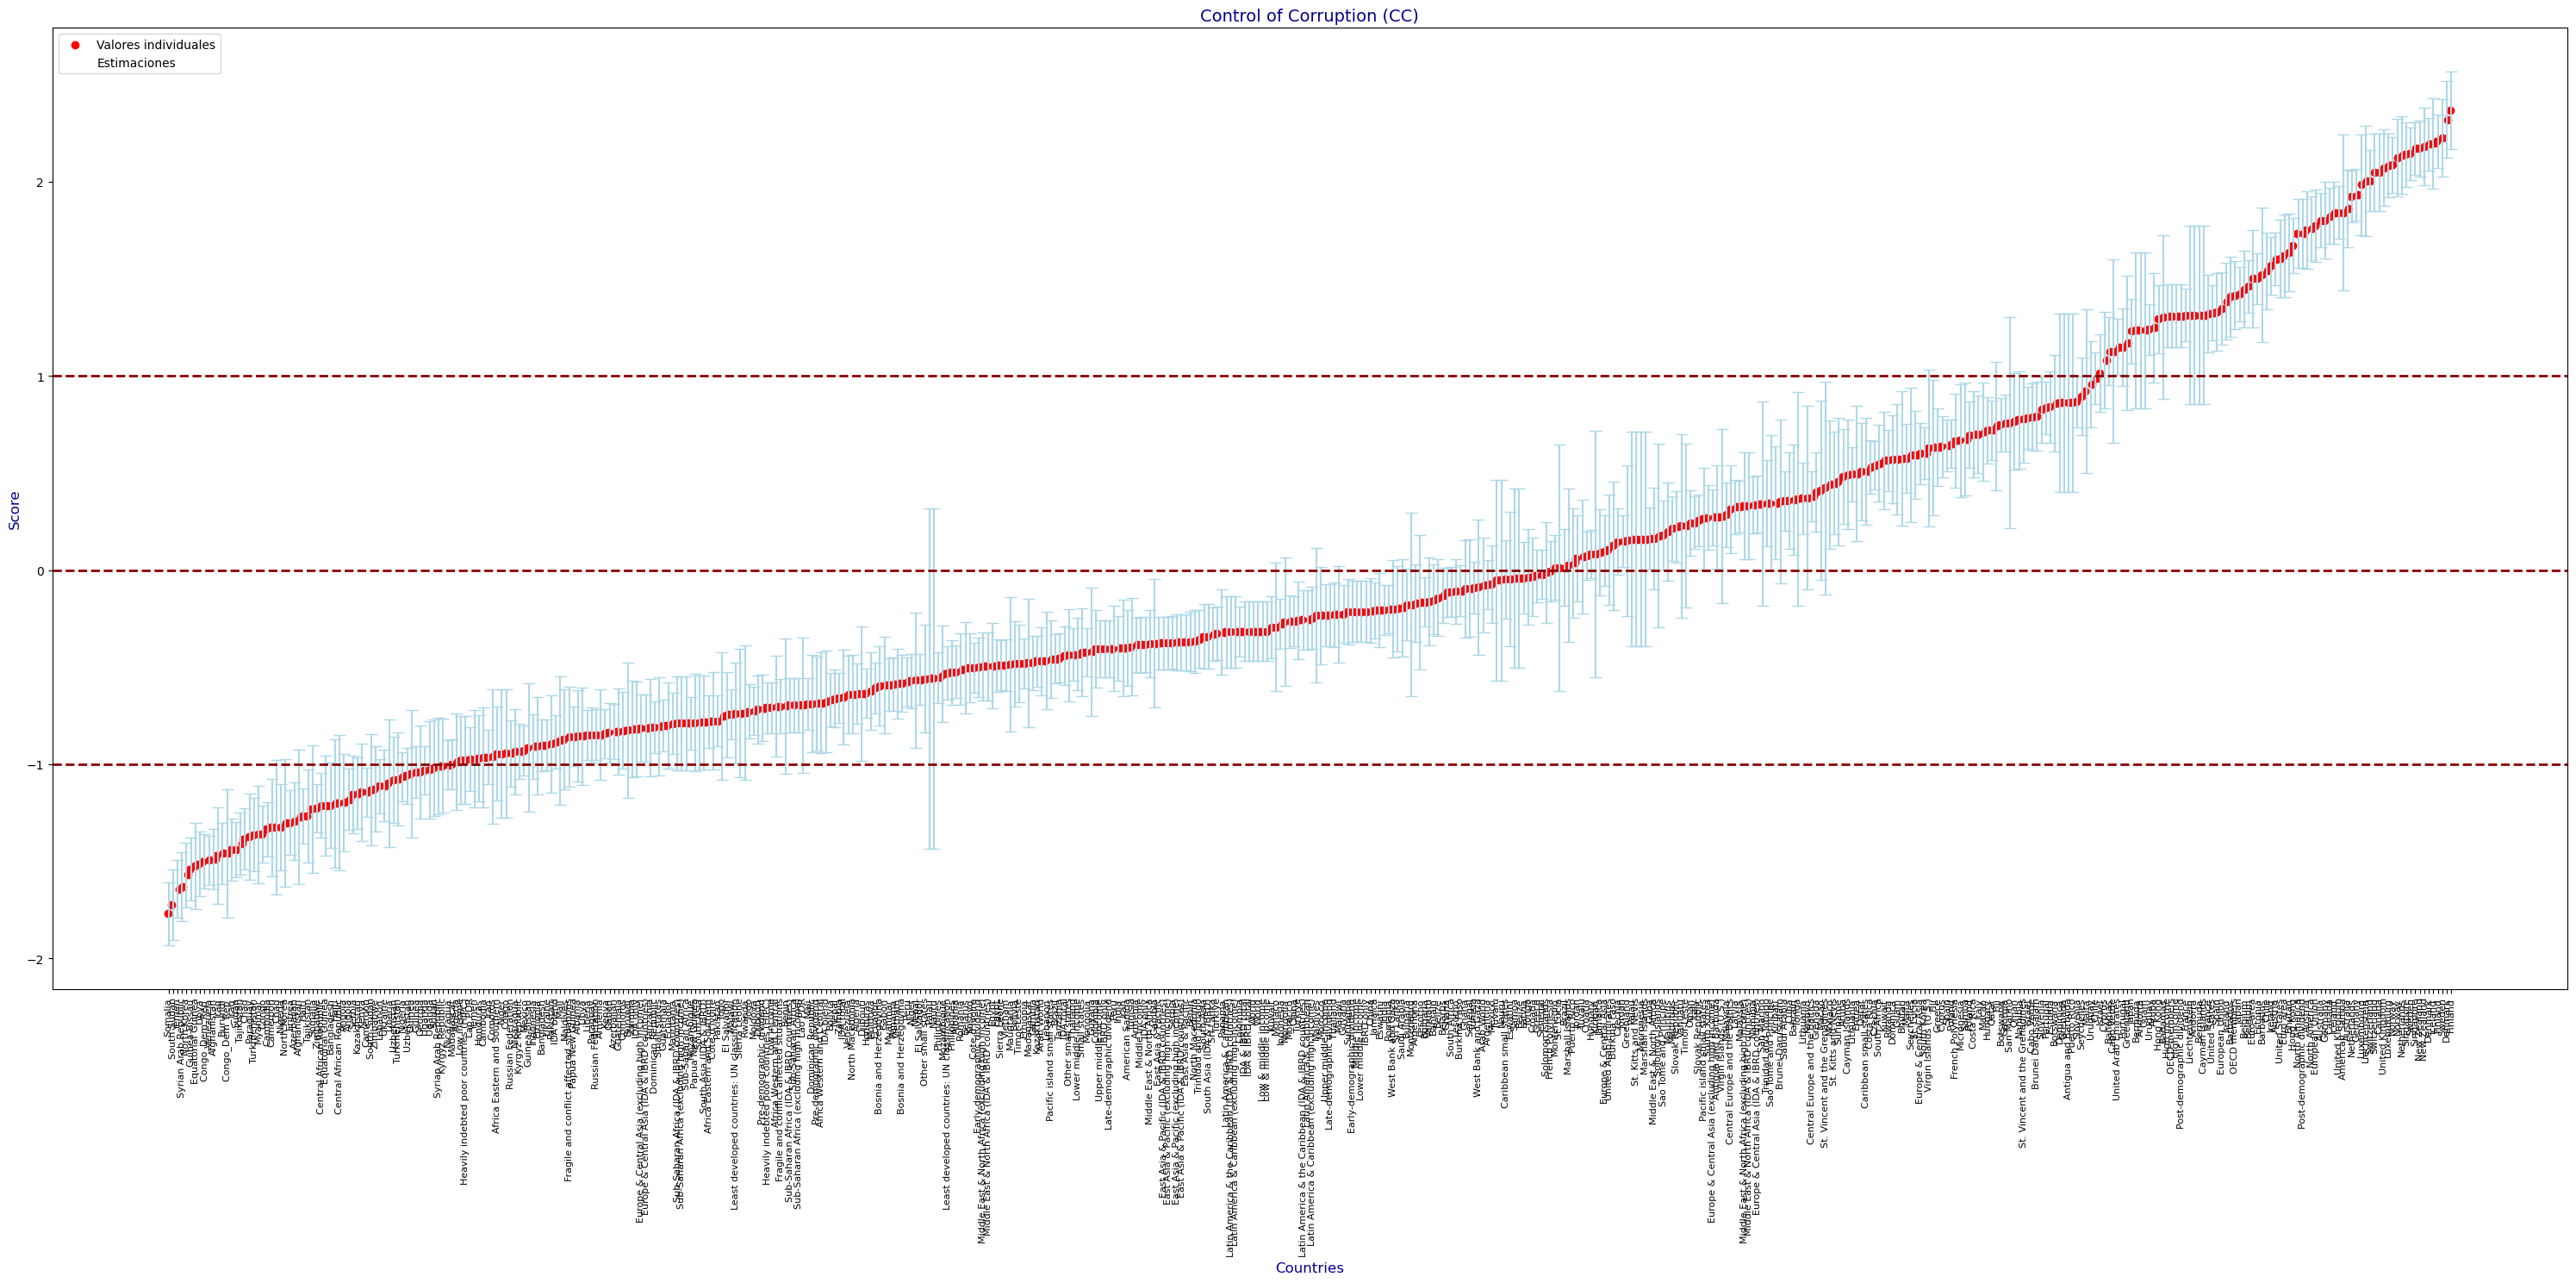

In [29]:
# Filtrar los datos relevantes
cc_data = imputed_df[['Country Name', 'CC.EST', 'CC.STD.ERR']]

# Ordenar los datos por el estimador (CC.EST)
cc_data = cc_data.sort_values(by='CC.EST')

# Crear coordenadas x para las barras
x = np.arange(len(cc_data))
w = 0.8 # Ancho de las barras

# Crear la figura
fig, ax = plt.subplots(figsize=(30, 15))

# Dibujar las barras con barras de error
bars = ax.bar(
    x,
    height=cc_data['CC.EST'],
    yerr=cc_data['CC.STD.ERR'],
    capsize=5,
    width=w,
    color='white',
    edgecolor='white',
    alpha=0.8,
    label='Estimaciones',
    ecolor='lightblue'
)

# Dibujar los puntos sobre las barras, distribuidos aleatoriamente
for i in range(len(x)):
    ax.scatter(
        x[i] + np.random.uniform(-w / 2, w / 2, size=1), # Dispersión aleatoria en ancho
        [cc_data['CC.EST'].iloc[i]], # Valor de Y
        color='red',
        label='Valores individuales' if i == 0 else "" # Etiqueta solo para el primer punto
    )

# Añadir líneas horizontales (guías)
for y in [-1, 0, 1]:
    ax.axhline(y=y, color='darkred', linestyle='--', linewidth=2)

# Configurar etiquetas y título
ax.set_xticks(x) # Ajustar los ticks al índice de las barras
ax.set_xticklabels(cc_data['Country Name'], rotation=90, fontsize=8) # Alinear etiquetas con las barras
ax.set_title('Control of Corruption (CC)', fontsize=14, color='darkblue')
ax.set_ylabel('Score', fontsize=12, color='darkblue')
ax.set_xlabel('Countries', fontsize=12, color='darkblue')

# Añadir la leyenda
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

El gráfico ilustra la distribución del indicador “Control of Corruption” (𝐶𝐶.𝐸𝑆𝑇 ) para los países del dataset. Cada barra de error representa la incertidumbre en las estimaciones (𝐶𝐶.𝑆𝑇 𝐷.𝐸𝑅𝑅) y los valores individuales están resaltados en rojo. Los elementos principales del gráfico son: 
1. Valores estimados (𝐶𝐶.𝐸𝑆𝑇 ): los puntos rojos representan los valores individuales estimados para cada país.
2. Barras de error: muestran la incertidumbre asociada con las estimaciones en ambos sentidos.
3. Líneas de referencia: las líneas horizontales en 𝐶𝐶.𝐸𝑆𝑇 = −1, 𝐶𝐶.𝐸𝑆𝑇 = 0, y 𝐶𝐶.𝐸𝑆𝑇 = 1 actúan como puntos de referencia para clasificar la gobernabilidad de cada país en términos de control de la corrupción.
4. Eje horizontal: los países están ordenados por sus valores de 𝐶𝐶.𝐸𝑆𝑇 , de menor a mayor, proporcionando una comparación clara y estructurada.

**Resultados principales**:
1. Países con bajos valores de 𝐶𝐶.𝐸𝑆𝑇 : países como Sudán, Angola y Yemen tienen valores de 𝐶𝐶.𝐸𝑆𝑇 por debajo de −1.5, indicando altos niveles de corrupción percibida y problemas significativos en el control de la misma. Las barras de error pequeñas para algunos de estos países sugieren que estas estimaciones son confiables.
2. Países con valores intermedios (−1 ≤ 𝐶𝐶.𝐸𝑆𝑇 ≤ 0): la mayoría de los países están agrupados en esta categoría, indicando niveles de corrupción percibida moderados. Ejemplos incluyen Brasil, India, y México, que a pesar de tener avances en gobernabilidad, aún enfrentan desafíos estructurales significativos.
3. Países con altos valores de 𝐶𝐶.𝐸𝑆𝑇 (𝐶𝐶.𝐸𝑆𝑇 > 1): países como Dinamarca, Noruega, y Singapur destacan por sus altos valores, reflejando sistemas sólidos de control anticorrupción. Estas naciones pueden considerarse modelos para políticas efectivas en gobernabilidad y transparencia.
4. Países con barras de error grandes: algunos países, como Micronesia o Timor-Leste, tienen barras de error relativamente amplias, lo que indica mayor incertidumbre en las estimaciones.

**Tendencias globales**:
1. Distribución general: existe una distribución continua de valores, con una mayor concentración de países en rangos intermedios (−1 ≤ 𝐶𝐶.𝐸𝑆𝑇 ≤ 0). Esto sugiere que la mayoría de las naciones enfrentan desafíos de corrupción, aunque con niveles variados de severidad.
2. Extremos opuestos: los extremos de la gráfica muestran claras diferencias entre países altamente corruptos
y aquellos con un fuerte control de la corrupción. Los países en los extremos pueden ser utilizados como referencias para identificar patrones comunes en gobernabilidad efectiva o inefectiva.

**Conclusión**: el gráfico de “Control of Corruption” revela importantes disparidades entre países en términos de control de la corrupción. Si bien hay una tendencia global hacia valores intermedios, los extremos destacan la urgencia de intervenciones específicas en naciones con altos niveles de corrupción. Por otro lado, los países con valores positivos reflejan sistemas fuertes de gobernabilidad que pueden servir de guía para políticas futuras.

Versión con **matplotlib**:

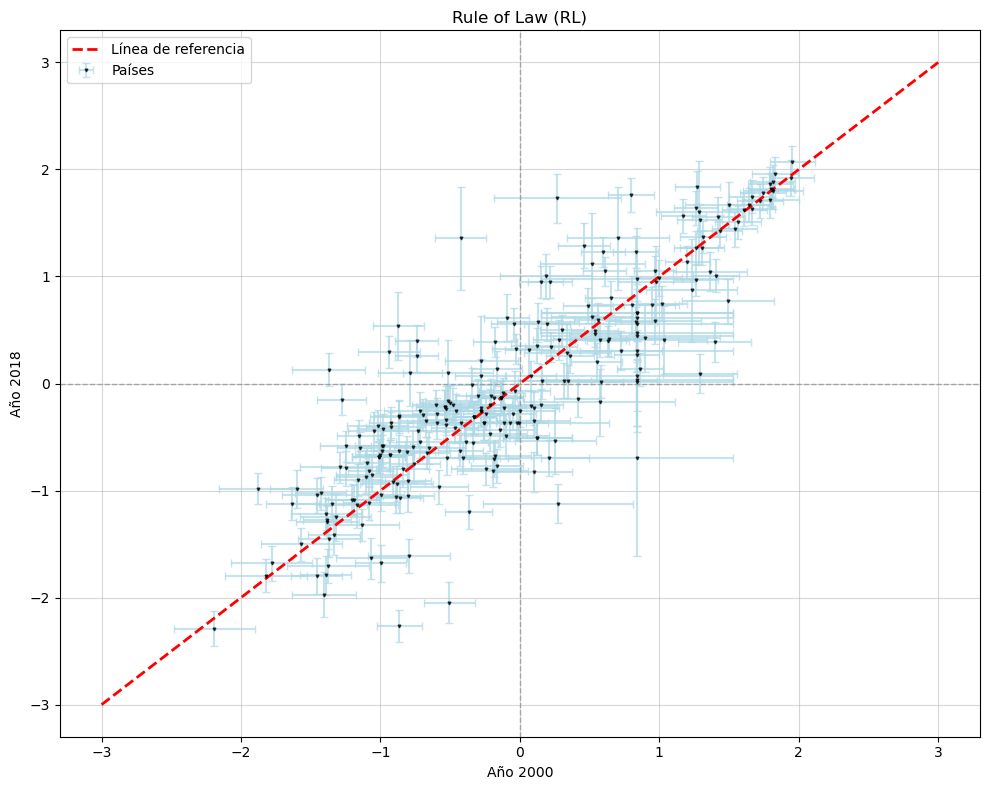

In [30]:
# Filtrar los datos relevantes para Rule of Law (RL)
rl_data = imputed_df[['Country Name', 'RL.EST', 'RL.STD.ERR', 'Year']].dropna()

# Filtrar los años 2000 y 2018
data_2000 = rl_data[rl_data['Year'] == '2000 [YR2000]']
data_2018 = rl_data[rl_data['Year'] == '2018 [YR2018]']

# Hacer un merge para comparar los mismos países en ambos años
merged_rl = pd.merge(
    data_2000[['Country Name', 'RL.EST', 'RL.STD.ERR']],
    data_2018[['Country Name', 'RL.EST', 'RL.STD.ERR']],
    on='Country Name',
    suffixes=('_2000', '_2018')
)

# Crear el gráfico
plt.figure(figsize=(10, 8))

# Dibujar puntos individuales con barras de error
plt.errorbar(
    merged_rl['RL.EST_2000'], # Valores del eje X (Año 2000)
    merged_rl['RL.EST_2018'], # Valores del eje Y (Año 2018)
    xerr=merged_rl['RL.STD.ERR_2000'], # Barras de error en X
    yerr=merged_rl['RL.STD.ERR_2018'], # Barras de error en Y
    fmt='v', # Formato de los puntos
    ecolor='lightblue', # Color de las barras de error
    color='black', # Color de los puntos
    alpha=0.7,
    label='Países',
    ms=2,
    capsize=3
)

# Añadir una línea de referencia diagonal
plt.plot(
    [-3, 3], # Rango del eje X
    [-3, 3], # Rango del eje Y
    color='red',
    linestyle='--',
    linewidth=2,
    label='Línea de referencia'
)

# Configurar etiquetas y título
plt.title('Rule of Law (RL)')
plt.xlabel('Año 2000')
plt.ylabel('Año 2018')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.6) # Línea horizontal en Y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.6) # Línea vertical en X=0
plt.grid(alpha=0.5)

# Añadir la leyenda
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

Versión con **seaborn**:

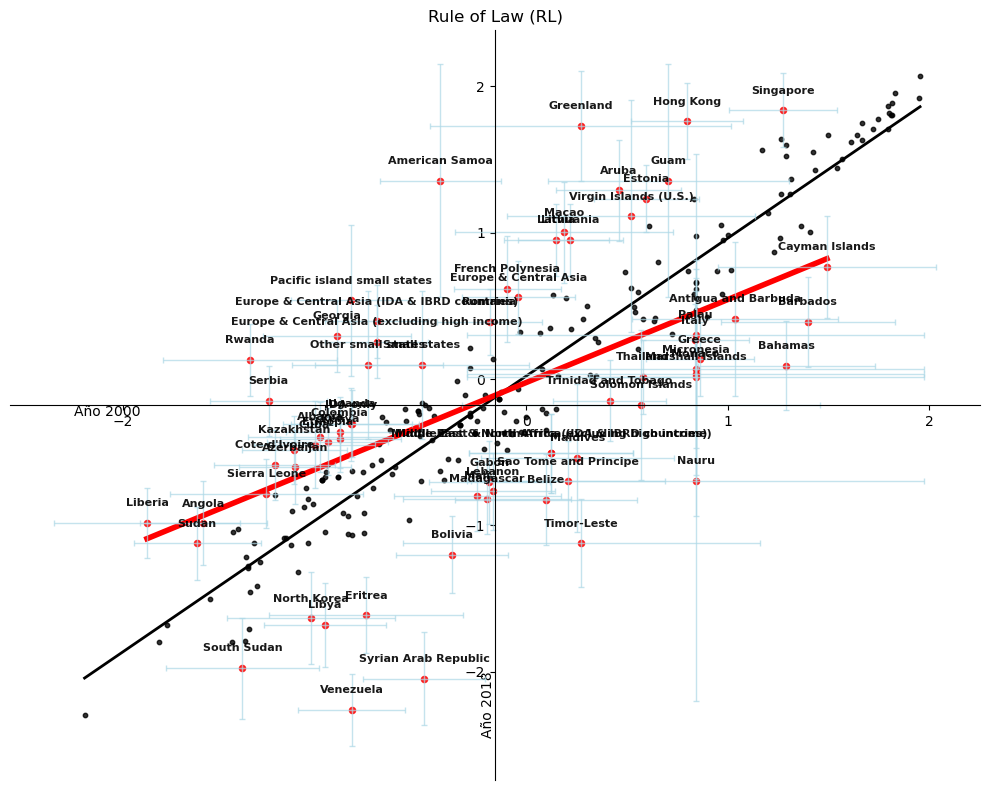

In [31]:
# Calcular residuos (distancia a la línea diagonal)
merged_rl['Residuals'] = (merged_rl['RL.EST_2018'] - merged_rl['RL.EST_2000']).abs()

# Definir un umbral para determinar "residuos altos" (países alejados de la línea diagonal)
threshold = 0.5 # Este umbral puede ajustarse según el análisis
residuos_altos = merged_rl[merged_rl['Residuals'] > threshold]
residuos_bajos = merged_rl[merged_rl['Residuals'] <= threshold]

# Crear el gráfico
plt.figure(figsize=(10, 8))

# Graficar los países con residuos bajos
sns.regplot(
    x='RL.EST_2000',
    y='RL.EST_2018',
    data=residuos_bajos,
    scatter_kws={'color': 'black', 's': 10, 'marker': 's'},
    line_kws={'color': 'black', 'linewidth': 2},
    ci=None
)

# Graficar los países con residuos altos
sns.regplot(
    x='RL.EST_2000',
    y='RL.EST_2018',
    data=residuos_altos,
    scatter_kws={'color': 'red', 's': 20, 'marker': 'D'},
    line_kws={'color': 'red', 'linewidth': 4},
    ci=None
)

# Añadir etiquetas a los países con residuos altos
z = 1.645 # Intervalo de confianza 90%
for i, row in residuos_altos.iterrows():
    
    # Barras de error
    plt.errorbar(
        x=row['RL.EST_2000'],
        y=row['RL.EST_2018'],
        xerr=row['RL.STD.ERR_2000'] * z,
        yerr=row['RL.STD.ERR_2018'] * z,
        fmt='none',
        ecolor='lightblue',
        elinewidth=1,
        capsize=2,
        alpha=0.7,
    )

    # Etiquetas
    plt.text(
        x=row['RL.EST_2000'],
        y=row['RL.EST_2018'] + 0.1,
        s=row['Country Name'],
        fontsize=8,
        fontweight='bold',
        color='black',
        ha='center',
        va='bottom',
        alpha=0.9
    )

# Configurar los ejes en el centro
plt.gca().spines['left'].set_position('center')
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')

# Añadir título y etiquetas de los ejes
plt.title("Rule of Law (RL)")
plt.xlabel('Año 2000')
plt.ylabel('Año 2018')

# Colocar las etiquetas de los ejes correctamente
plt.gca().yaxis.set_label_coords(0.5, 0.1)
plt.gca().xaxis.set_label_coords(0.1, 0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El gráfico generado compara el indicador Rule of Law (RL.EST) entre los años 2000 y 2018 para los mismos países. Los puntos de dispersión representan los valores estimados (RL.EST) en cada año, y las barras de error visualizan la incertidumbre asociada con las estimaciones (RL.STD.ERR).
Este análisis sirve para:
- Visualizar cambios: Evaluar cómo ha evolucionado el estado de derecho en diferentes países a lo largo del tiempo.
- Identificar tendencias globales: Una diagonal cercana a 𝑦 = 𝑥 indicaría poca variación entre los años comparados, mientras que desviaciones importantes revelan mejoras o deterioros significativos.
- Considerar la incertidumbre: Las barras de error permiten incluir el margen de incertidumbre en las interpretaciones, evitando conclusiones precipitadas basadas en valores puntuales.

#### Resultados principales
1. Países con mejoras significativas (𝑦 > 𝑥): países como Hong Kong, Singapur y Groenlandia se encuentran notablemente por encima de la línea diagonal. Esto sugiere que han experimentado mejoras significativas en su estado de derecho entre 2000 y 2018. Estas mejoras pueden deberse a políticas específicas, estabilidad política o programas de fortalecimiento institucional.
2. Países con deterioros significativos (𝑦 < 𝑥): Sudán del Sur, Libia, Eritrea y Venezuela están significativamente por debajo de la línea diagonal, indicando un fuerte deterioro en su gobernabilidad. Este deterioro podría atribuirse a conflictos internos, colapso institucional o falta de políticas efectivas.
3. Países con barras de error grandes: algunos países, como Sierra Leona y Timor-Leste, tienen barras de error más grandes, lo que indica una alta incertidumbre en las estimaciones. Estos casos deben interpretarse con precaución, ya que los datos pueden no ser completamente confiables.
4. Tendencia global: la mayoría de los puntos se encuentran cerca de la diagonal, lo que sugiere que los cambios en 𝑅𝐿.𝐸𝑆𝑇 han sido modestos a nivel global. Sin embargo, hay un grupo notable de países con residuos altos, destacando la variabilidad en la evolución del indicador entre diferentes regiones.

#### Conclusión
El gráfico refleja una tendencia general de estabilidad, con excepciones notables tanto de mejora como de deterioro. Este análisis destaca la importancia de políticas específicas y contextos regionales en la evolución del estado de derecho. Países como Sudán y Venezuela representan casos críticos, mientras que Hong Kong y Singapur muestran cómo las estrategias acertadas pueden traducirse en avances significativos.